# Author: Johanna

We use this notebook to plot the ROC curve for any previously trained model and find the optimal prediction threshold. We then use the new threshold to find the best Precision and Recall.

First, we do the usual setup.

In [ ]:
import os 
import datetime
import json
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import tensorflow as tf

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
load_dotenv(find_dotenv())
basepath = Path(os.getcwd())

%load_ext autoreload
%autoreload 2
basepath

In [ ]:
# Specify which GPU(s) to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Or 2, 3, etc. other than 0

#config = tf.compat.v1.ConfigProto(device_count={'GPU': 1}, allow_soft_placement=True, log_device_placement=True)
config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 1.2
tf.compat.v1.Session(config=config)
tf.__version__

In [3]:
import numpy as np

import traceback
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils.generic_utils import get_custom_objects

from tensorflow.keras.applications import InceptionV3, Xception, DenseNet121, InceptionResNetV2, ResNet152V2, NASNetLarge
from src.architectures.simple.simple_base import SimpleBaseArchitecture
from src.architectures.simple.load_model import *
from src.architectures.benchmarks.benchmark import Benchmark, Experiment
from src.architectures.benchmarks.benchmark_definitions import generate_benchmarks,simple_architecture_experiment, Chexpert_Benchmark, CHEXPERT_COLUMNS, METRICS, SINGLE_CLASS_METRICS
from src.metrics.metrics import F2Score, SingleClassMetric
from src.metrics.losses import WeightedBinaryCrossentropy, compute_class_weight

We load the model we want to evaluate.

In [ ]:
experiments = get_all_experiment_logs()
experiments = [exp for exp in experiments if "Failed" not in exp["name"]]
experiments = [exp for exp in experiments if "num_samples_test" in exp["benchmark"].keys() ]
experiments = [exp for exp in experiments if exp["benchmark"]["num_samples_test"] == 234 ]
len(experiments)

In [ ]:
experiments
exp_dict = experiments[31].copy()
exp_dict["name"], exp_dict["test"]["auc"]

We plot the ROC curve individually for all classes.

Using weights file DenseNet121_2_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled_20200829-114238.h5 to load model...


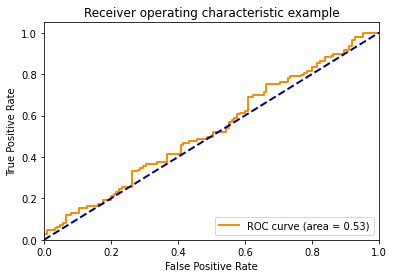

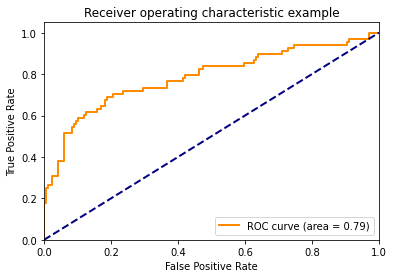

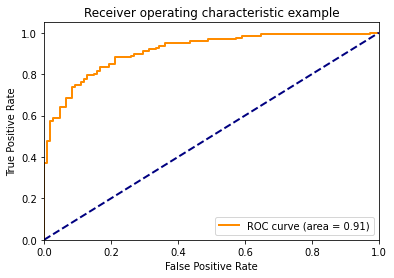

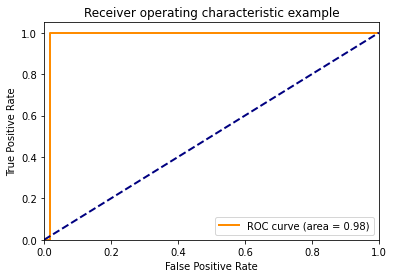

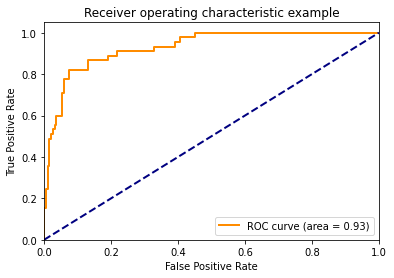

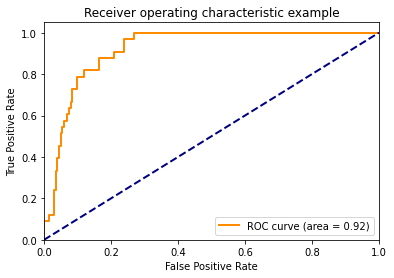

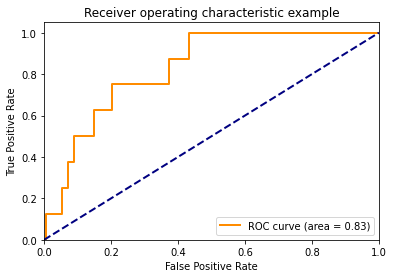

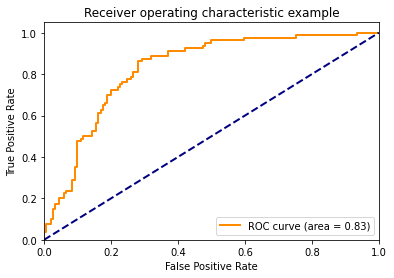

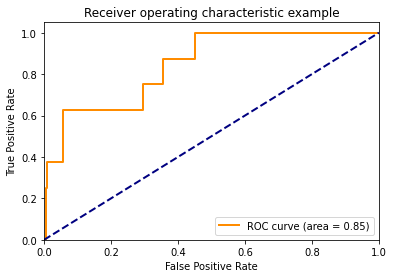

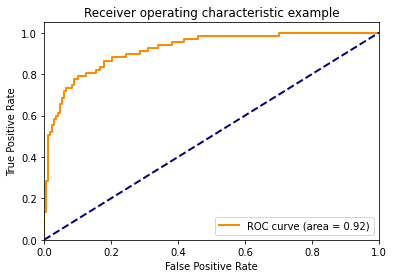

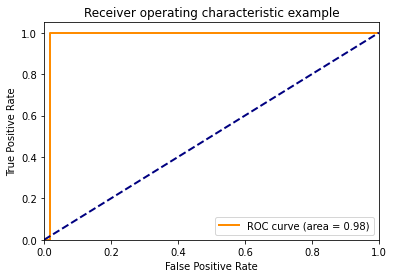

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


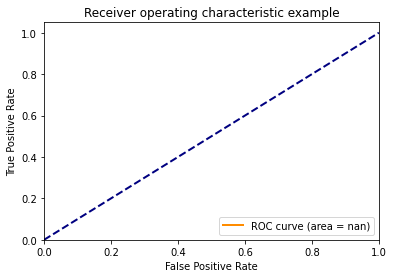

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


exp = rebuild_experiment(exp_dict)
predictions = exp.model.predict(exp.benchmark.testgen)
groundtruth = exp.benchmark.testgen.get_labels_nonan()
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, 12):
    fpr[i], tpr[i], _ = roc_curve(groundtruth[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

We then plot the TPR and the 1-FPR for visualization and calculate the optimal threshold.

59    0.079847
Name: thresholds, dtype: float32
37    0.040465
Name: thresholds, dtype: float32
28    0.090263
Name: thresholds, dtype: float32
3    0.497373
Name: thresholds, dtype: float32
24    0.180125
Name: thresholds, dtype: float32
31    0.141923
Name: thresholds, dtype: float32
12    0.155438
Name: thresholds, dtype: float32
48    0.15357
Name: thresholds, dtype: float32
8    0.046542
Name: thresholds, dtype: float32
36    0.080998
Name: thresholds, dtype: float32
3    0.652152
Name: thresholds, dtype: float32
2    0.001525
Name: thresholds, dtype: float32


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


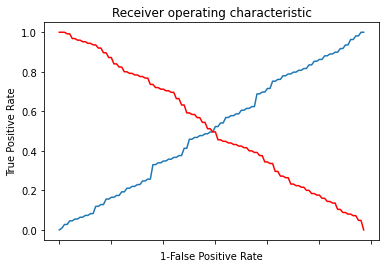

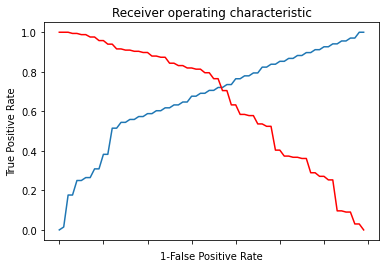

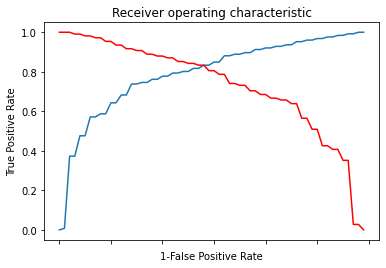

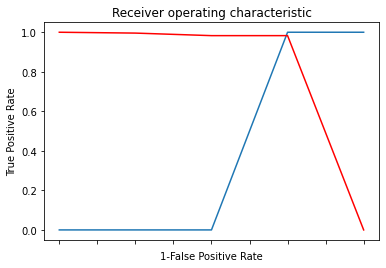

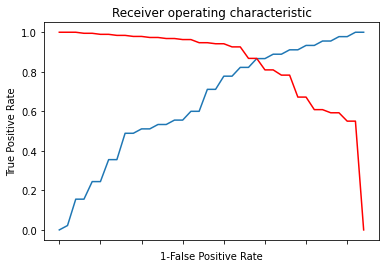

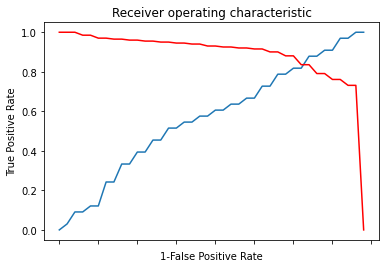

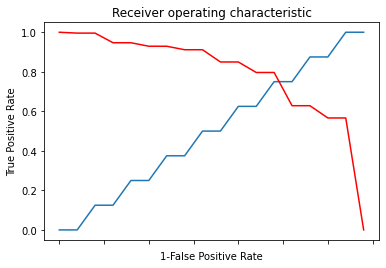

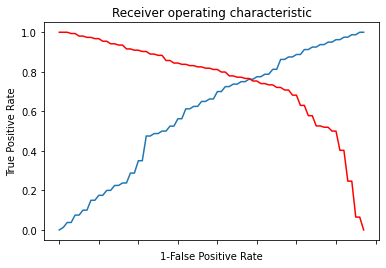

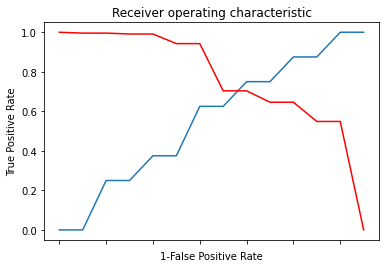

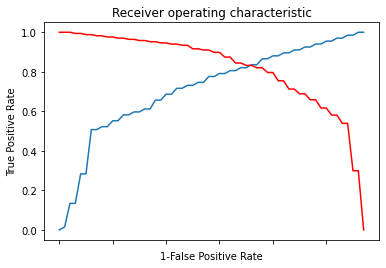

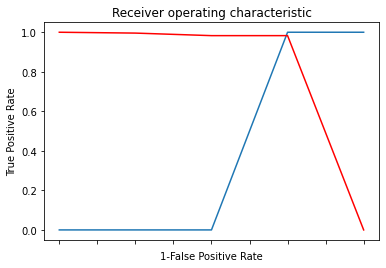

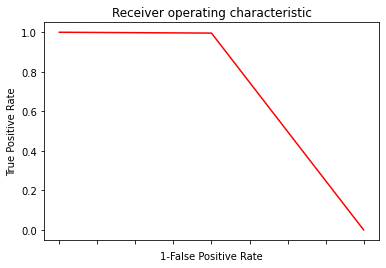

In [13]:
import pandas as pd

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, 12):
    fpr, tpr, thresholds =roc_curve(groundtruth[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr[i], index=i),'tpr' : pd.Series(tpr[i], index = i), '1-fpr' : pd.Series(1-fpr[i], index = i), 'tf' : pd.Series(tpr[i] - (1-fpr[i]), index = i), 'thresholds' : pd.Series(thresholds[i], index = i)})
    roct = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    print(roct['thresholds'])

    # Plot tpr vs 1-fpr
    fig, ax = plt.subplots()
    plt.plot(roc['tpr'])
    plt.plot(roc['1-fpr'], color = 'red')
    plt.xlabel('1-False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ax.set_xticklabels([])

We then use the new threshold to recalculate Precision and Recall.

In [24]:
for index in range(0, 12):
    print('current threshold: ', ths[index])
    predictions_bool = (predictions >= ths[index])
    y_pred = np.array(predictions_bool[:, index], dtype=int)

    pre = Precision()
    pre.update_state(np.array(groundtruth[:, index], dtype=int), y_pred)
    print('TF Precision: ', pre.result())
    pre.reset_states()
    
    rec = Recall()
    rec.update_state(np.array(groundtruth[:, index], dtype=int), y_pred)
    print('TF Recall: ', rec.result())
    rec.reset_states()
    print("...")

current threshold:  0.079847
TF Precision:  tf.Tensor(0.46153846, shape=(), dtype=float32)
TF Recall:  tf.Tensor(0.49541286, shape=(), dtype=float32)
...
current threshold:  0.040465
TF Precision:  tf.Tensor(0.5051546, shape=(), dtype=float32)
TF Recall:  tf.Tensor(0.7205882, shape=(), dtype=float32)
...
current threshold:  0.090263
TF Precision:  tf.Tensor(0.852459, shape=(), dtype=float32)
TF Recall:  tf.Tensor(0.82539684, shape=(), dtype=float32)
...
current threshold:  0.1
TF Precision:  tf.Tensor(0.012820513, shape=(), dtype=float32)
TF Recall:  tf.Tensor(1.0, shape=(), dtype=float32)
...
current threshold:  0.180125
TF Precision:  tf.Tensor(0.6031746, shape=(), dtype=float32)
TF Recall:  tf.Tensor(0.84444445, shape=(), dtype=float32)
...
current threshold:  0.141923
TF Precision:  tf.Tensor(0.45762712, shape=(), dtype=float32)
TF Recall:  tf.Tensor(0.8181818, shape=(), dtype=float32)
...
current threshold:  0.155438
TF Precision:  tf.Tensor(0.09803922, shape=(), dtype=float32)
TF